In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table
import csv
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import emcee
import corner

In [2]:
data = Table.read("pleiadi_817", format= "ascii" )

In [3]:
data;

In [4]:
pmRA = data["pmRA"]
pmDE = data["pmDE"]
RA = data["RArad"]
DE = data["DErad"]
Plx = data["Plx"]
e_plx = data["e_Plx"]

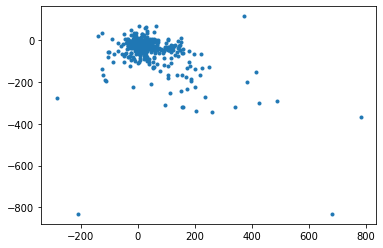

In [5]:
plt.plot(pmRA, pmDE, '.')

(-60.0, 20.0)

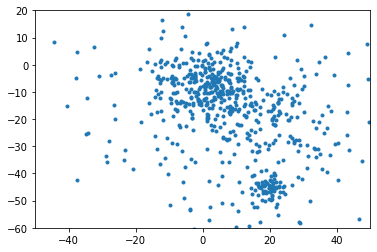

In [6]:
plt.plot(pmRA, pmDE, '.')
plt.xlim(-50,50)
plt.ylim(-60,20)

In [7]:
def sum_err(e_plx, sigma_cl):
    return sigma_cl**2 + e_plx**2

def loglikelihood(par, Plx, e_plx):
    Pcl, sigma_cl = par
    err = sum_err(e_plx, sigma_cl)
    return -0.5 * np.sum(np.log(2*np.pi) + np.log(err) + (Plx - Pcl)**2/((err)))
    
def loglikelihood2(par2, Plx, e_plx):
    Pcl, sigma_cl, f = par2
    err = sum_err(e_plx, sigma_cl)
    return np.sum(np.logaddexp(np.log(f) - 0.5 * (np.log(2*np.pi) + np.log(err) + (Plx - Pcl)**2/(err)), np.log(1-f) + np.log(1/19)))

In [8]:
Pcl_min = 1
Pcl_max = 20
sigma_cl_min = 0
sigma_cl_max = 5
f_min = 0
f_max = 1

def logprior(par):
    Pcl, sigma_cl = par
    if Pcl < Pcl_min or Pcl > Pcl_max or sigma_cl < sigma_cl_min or sigma_cl > sigma_cl_max:
        return -np.inf
    else:
        return -np.log((Pcl_max - Pcl_min)*(sigma_cl_max - sigma_cl_min))
    
def logprior2(par2):
    Pcl, sigma_cl, f = par2
    if Pcl < Pcl_min or Pcl > Pcl_max or sigma_cl < sigma_cl_min or sigma_cl > sigma_cl_max or f < f_min or f > f_max:
        return -np.inf
    else:
        return -np.log((Pcl_max - Pcl_min)*(sigma_cl_max - sigma_cl_min)*(f_max - f_min))

In [9]:
def logposterior(par, Plx, e_plx):
    lp = logprior(par)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + loglikelihood(par, Plx, e_plx)
    
def logposterior2(par2, Plx, e_plx):
    lp2 = logprior2(par2)
    if not np.isfinite(lp2):
        return -np.inf
    else:
        return lp2 + loglikelihood2(par2, Plx, e_plx)

In [55]:
Y = np.zeros((len(pmRA), 2))

for i in range(len(pmRA)):
    Y[i,0] = pmRA[i]
    Y[i,1] = pmDE[i]

In [56]:
Y;

In [57]:
gm = GaussianMixture(n_components=5, random_state=0, n_init=100, 
                     init_params="random", covariance_type = 'spherical').fit(Y)

In [58]:
gm.means_

array([[   1.41812878,   -7.80641928],
       [  19.82929007,  -45.34312609],
       [  12.8360411 ,  -20.65798795],
       [ 182.35166977, -234.79154097],
       [  48.38936955,  -46.47546817]])

In [59]:
labels = gm.predict(Y)

In [60]:
labels;

(-100.0, 100.0)

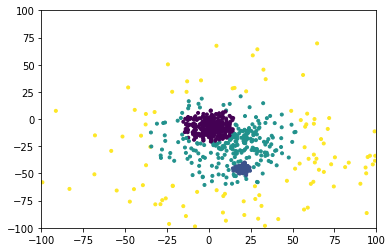

In [61]:
plt.scatter(Y[:,0], Y[:,1], c = labels, marker = '.')
plt.xlim(-100,100)
plt.ylim(-100,100)

In [62]:
gm.predict_proba(Y)

array([[1.30650739e-049, 0.00000000e+000, 5.97505725e-006,
        1.61265847e-002, 9.83867440e-001],
       [7.40914215e-001, 7.26255131e-091, 2.30662529e-001,
        3.07554480e-004, 2.81157011e-002],
       [8.93707990e-001, 1.70132644e-056, 1.00533443e-001,
        5.30487436e-005, 5.70551741e-003],
       ...,
       [8.66220722e-001, 2.79532943e-051, 1.26732024e-001,
        6.47284502e-005, 6.98252549e-003],
       [5.10516313e-001, 1.76457098e-031, 4.67541959e-001,
        1.84379852e-004, 2.17573483e-002],
       [5.90995714e-027, 5.54962680e-112, 1.91956234e-002,
        9.17750516e-003, 9.71626871e-001]])

In [63]:
data['prob'] = gm.predict_proba(Y)

In [64]:
data;

In [65]:
prob = data['prob']
p = prob[:,1]
mask = [(p > 0.10)]

Plxs = Plx[tuple(mask)]
e_plxs = e_plx[tuple(mask)]

In [66]:
len(Plxs)

78

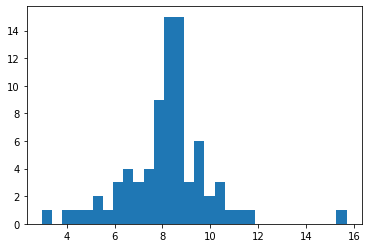

In [67]:
plt.hist(Plxs, bins=30);

In [68]:
soln = [np.random.uniform (Pcl_min, Pcl_max), np.random.uniform(sigma_cl_min, sigma_cl_max)]

pos = soln + 1e-4 * np.random.randn(7, 2)
nwalkers, ndim = pos.shape

#for i in range(len(pPlx_)):
    #sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(pPlx_[i], pe_plx_[i]))
sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args=(Plxs, e_plxs))

sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:14<00:00, 707.13it/s]


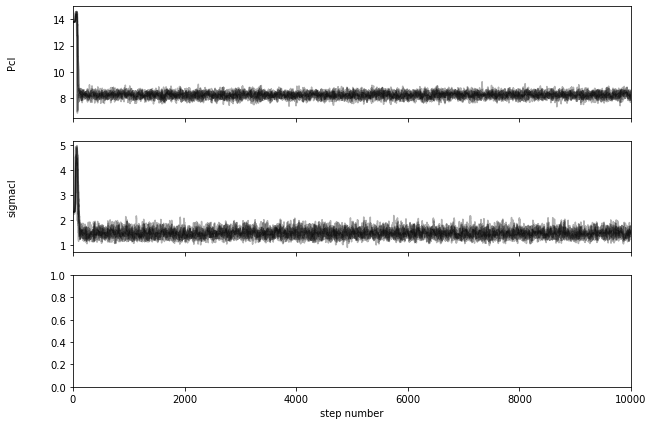

In [69]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Pcl", "sigmacl"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [70]:
tau = sampler.get_autocorr_time()
print(tau)

[78.62046277 61.54064724]


(69300, 2)


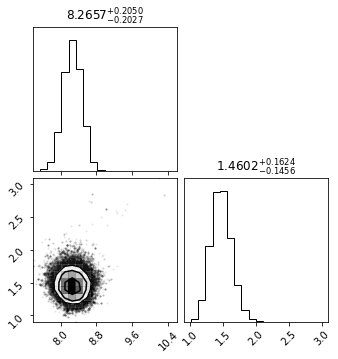

In [71]:
flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples,
    show_titles=True,
    title_fmt='.4f'
);
plt.savefig('Dati_2.pdf')

In [27]:
soln2 = [np.random.uniform (Pcl_min, Pcl_max), np.random.uniform(sigma_cl_min, sigma_cl_max), np.random.uniform(f_min, f_max)]

pos2 = soln2 + 1e-4 * np.random.randn(15, 3)
nwalkers2, ndim2 = pos2.shape

sampler = emcee.EnsembleSampler(nwalkers2, ndim2, logposterior2, args=(Plxs, e_plxs))

sampler.run_mcmc(pos2, 10000, progress=True);

100%|██████████| 10000/10000 [00:29<00:00, 334.85it/s]


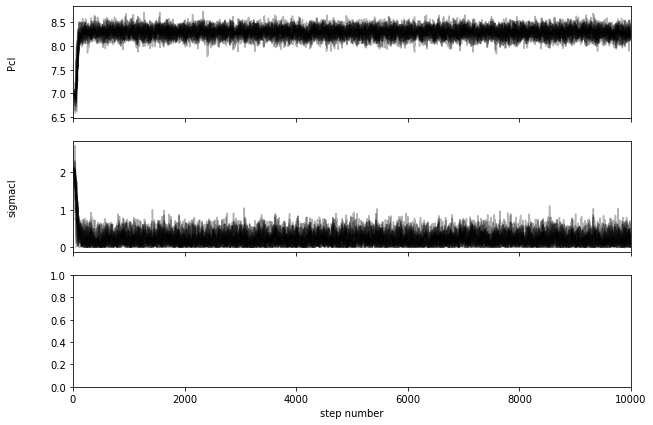

In [28]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Pcl", "sigmacl", "f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [29]:
tau = sampler.get_autocorr_time()
print(tau)

[72.15705244 62.99615493 54.32721539]


(148500, 3)


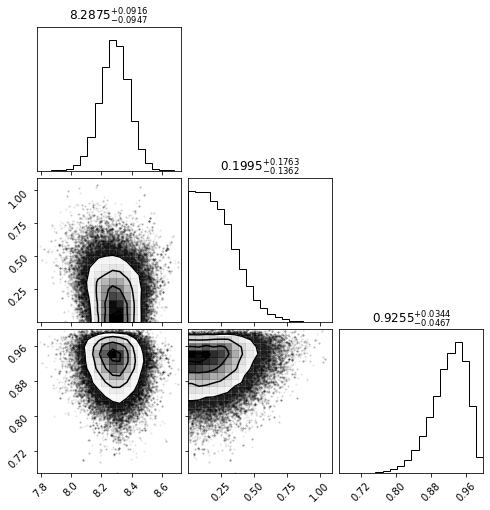

In [30]:
flat_samples2 = sampler.get_chain(discard=100, thin=1, flat=True)
print(flat_samples2.shape)

fig = corner.corner(
    flat_samples2,
    show_titles=True,
    title_fmt='.4f'
);

In [40]:
len(flat_samples[:,0])

69300

In [42]:
z = np.zeros((len(flat_samples),1))
#np.c_[ flat_samples, np.ones(N) ] 
#figure = corner.corner(flat_samples2);
#corner.corner(flat_samples, fig = figure);

In [50]:
flat_samples = np.append(flat_samples, z, axis=1)

In [51]:
flat_samples

array([[8.04372735, 1.63326859, 0.        ],
       [8.19108688, 1.30405498, 0.        ],
       [8.18496067, 1.66722943, 0.        ],
       ...,
       [8.19914269, 1.52333497, 0.        ],
       [8.14299511, 1.42800702, 0.        ],
       [8.19428854, 1.49017056, 0.        ]])

ValueError: It looks like the parameter(s) in column(s) 2 have no dynamic range. Please provide a `range` argument.

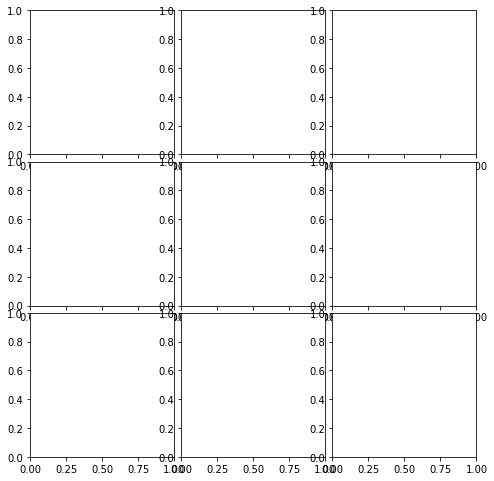

In [53]:
fig = corner.corner(
    flat_samples,
    show_titles=True,
    title_fmt='.4f'
);
#corner.corner(flat_samples2,fig=figure)